# AiDM 2019: Assignment 1 - Recommender Systems

## Part 2: Matrix factorization

Auke Bruinsma, s1594443 and Simon van Wageningen, s2317079

As instructed, we have divided the first assignment of AiDM into two parts: The first on the naive models and this part on the matrix factorization. The structure of this part will be as follows: Before each cell of code we'll provide background info in markdown cells if necessary. If a cells produces relevant output we'll write this down. At the end there will be a short conclusion/discussion section where we compare our results of the naive models and matrix factorization with each other.

In [1]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from numpy import genfromtxt
import sys

In the following cell we import the three datasets using pandas. We have given each columns the names that are found in the readme file so that each column can be accesed with, for example, ratings['UserID'].

In [2]:
# Import datasets and infer a header with the correct column labels.
ratings = pd.read_csv(filepath_or_buffer='data/ml-1m/ratings.dat',sep='::',header=None,names=['UserID','MovieID','Rating','Timestamp'])
users = pd.read_csv(filepath_or_buffer='data/ml-1m/users.dat',sep='::',header=None,names=['UserID','Gender','Age','Occupation','Zip-code'])
movies = pd.read_csv(filepath_or_buffer='data/ml-1m/movies.dat',sep='::',header=None,names=['MovieID','Title','Genres'])

/home/auke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/home/auke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/auke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by spec

### 1. Create the array $X$

Now that we have imported all necessary packages and datasets, we can start with the assignment. After a quick look at the data, we noticed the following things:

- There are approximately 6000 users.
- There are approximately 4000 movies.
- Not every users has rated each movie.
- Sometimes the ['MovieID'] column skips a number. This may mean that a movie is deleted from the database, or that no one has rated that movie. 

In order to complete the matrix factorization, we will create a matrix called $X$. This matrix has approximately the size $(6000,4000)$, where $X_{i,j}$ denotes how the $i_{th}$ user will rate the $j_{th}$ movie. Because of the last two points in the previous enumeration, there are a lot of empty elements in this matrix. Approximately 4.2 percent of the matrix $X$ has elements that are not equal to zero, which means 4.2 percent has been rated.

In [3]:
# Create array X with at X[i][j] the ratings for how the ith user would rate the jth movies
X = np.zeros((users['UserID'][len(users)-1]+1,movies['MovieID'][len(movies)-1]+1))

# Fill array.
for k in range(len(ratings)):
    X[ratings['UserID'][k]][ratings['MovieID'][k]] = ratings['Rating'][k]

In this cell we compute the percentage filled of the matrix $X$.

In [4]:
# To get a better ovewview, here we print the number of matrix elements that is known.
print('Percentage filled: {0} %'.format(100*len(ratings)/(len(X)*len(X[0]))))

Percentage filled: 4.188467095557036 %


The exact shape of the matrix $X$ is (6041,3953)$ and it also printed for a quick overview. You can see that that most elements are zero and only two elements have a rating.

In [5]:
print('Shape X: {0}\n'.format(X.shape))
print(X)

Shape X: (6041, 3953)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]]


Now we have the imported data in a matrix $X$. This matrix will form the basis of the computations that are needed to perform the matrix factorization. However, first we need to set up the N-fold cross validation.

### 2. N-fold cross-validation:

1. Split your data in $N$ parts (equal size);
2. Develop $N$ models on all combinations of $(N-1)$ parts;
3. Test each model on the remaining parts (test sets);
4. Average the errors over these $N$ test sets;
5. The average error is a realistic estimator of the error made by your model on the fresh data.

#### In practice:
- $N=5$ (5-fold cross-validation) or $(N=10)$ (10-fold cross-validation)
- Errors also measured on the training sets/folds
- Standard deviation of errors says something about 'model stability'

The text in the previous cell is taken from the slides. The idea of N-fold cross validation is to create your own training and testing set so that you can test the accuracy of your model. You divide all your data in $N$ parts, in our case 5 parts. Then 4/5 is used as a training set and 1/5 as a testing set. Yobu repeat this process for each one-fifth of the data, so that every one-fifth is used for testing, and each 4/5 is used for the training set. This will give an accurate outcome of the model.

The splitting of the data in 5 parts is done in the following way: All the indices of the elements of the matrix $X$ which are not equal to zero, are stored in an list called non_zero_indices. Each element of this array contains the $i$-coordinate, $j$-coordinate, and also the rating. This means the size of this array is $(1000209,3)$, since there are $1000209$ ratings present in the matrix $x$. Next, the non_zero_indices array is random shuffled, to make the training set a bit more valid. The array is then splitted into 5 parts, and this array is returned by the function k_fold_cross_validation. The size of this list is $(n=5,~10^6/(n=5),3)$.

In [6]:
# Create an array where all the indices will be stored which are not zero.
non_zero_indices = []
for i in range(len(X)):
    for j in range(len(X[i])):
        if X[i][j] != 0:
            non_zero_indices.append((i,j,X[i][j])) # Has length 1.000.209.

The above coding cell creates the array with the indices of the elements that have a rating. The code cell below is the function that randomly shuffles the data and splits it into 5 parts.

In [7]:
def k_fold_cross_validation(data,k):
    np.random.shuffle(data)
    splitted_data = []
    for i in range(k):
        splitted_data.append(data[int(len(data)/k*i):int(len(data)/k*(i+1))])
        print('Size set {0}: {1}'.format(i+1,np.shape(splitted_data[i])))
    return splitted_data    

In [8]:
folded_data = k_fold_cross_validation(non_zero_indices,k=5)

Size set 1: (200041, 3)
Size set 2: (200042, 3)
Size set 3: (200042, 3)
Size set 4: (200042, 3)
Size set 5: (200042, 3)


Above is some output that displays the size of each of the 5 sets. Each set contains approximately $2*10^5$ datapoints/ratings.

Now we have set up our data in 5 different parts. Next is the actual process called matrix factorization.

### 3. Matrix factorization.

The following equations are taken from the gravity-tikk paper page 24.

The matrix $X$ can be approximated as the product of two matrices:

$$X \approx UM $$

$X$ has shape $(i,j)$ where $i$ denotes the $i$th user and $j$ denotes the $j$th movie. The actual element $(i,j)$ contains the rating the user has given the movie. The matrices $U$ and $M$ have shapes $(i,k)$ and $(k,j)$, respectively. $k$ is a factor which can be chosen. In the code this will simply be called $k$ and experimentation will be done with this value. Now, instead of having a single matrix with approximate size $(6000,4000)$, you have two matrices with sizes $(6000,k)$ and $(k,4000)$, which is much less data. The key idea is that the product of the matrices $U$ and $M$ will give accurate predictions of what rating a certain user will give to movie he hasn't rated yet, based on his/hers known ratings.

How we do obtain the matrix elements of $U$ and $M$? We initialise the matrices with random weight produced by numpy.random.randn, which all values obtained from a gaussian distribution. The elements of $U$ and $M$ are then constantly updated over several iterations. They are computed with the following equations.

$$ \hat{x}_{ij} = \sum_{k=1}^{K} = u_{ik}m_{kj} $$

$ \hat{x}_{ij} $ denotes the predicted values of what user $i$ will rate movie $j$. Next the error of the predicted value compared to the known value is computed. This is done only for values which are known, so for the total $1000209$ ratings given by the $6041$ users.

$$ e_{ij} = x_{ij}-\hat{x}_{ij} $$

The total error of all these ratings is just the sum of the errors:

$$ SE = \sum_{ij} e^2_{ij} $$

What you want, is to minimize the total error over time. The new values for the elements in the matrices $U$ and $M$ is computed with the two following algorithms:

$$ u`_{ik}  = u_{ik} + \eta \cdot (2 e_{ij} \cdot m_{kj} - \lambda \cdot u_{ik} ) $$
$$ m`_{kj}  = m_{kj} + \eta \cdot (2 e_{ij} \cdot u_{ik} - \lambda \cdot m_{kj} ) $$

$ u`_{ik} $ is the updated parameter value. $\eta$ is the learning rate, so it specifies how fast the algorithm learns. $\lambda$ is the regularization factor to prevent large weights.

After these computations are performed on the training set. The new matrices $U$ and $M$ are computed and the equations that compute the predicted matrix values $\hat{x}_{ij}$ and the (total) error are computed on the test set. From this error the RMSE can be computed. This is just the square root of the mean of the total error. This value usually starts out high, around 3 are 4, then rapidly decreases in the first few iterations and then slowly drops to 0.9 or 0.8, depending on the initial parameter values for the learning rate and regularization value. The iteration process will be stopped of the error increases. That means no further improvement can be obtained using the algorithm.

In [13]:
def mat_fac(indices,X,test_set):
    # Initial parameters. Set eta and lambda to some small positive values.
    eta = 0.005 # Learning rate (eq. 6 gravity-tikk).
    lamda = 0.05 # The regularization factor lambda (eq. 6 gravity-tikk).
    k = 12 # The parameter that sets the shape of the matrices U and M.
    n_iter = 100 # Number of maximum iterations.

    # Initialise the two matrices (eq. 1 gravity-tikk)
    U = np.random.randn(users['UserID'][len(users)-1]+1,k) # Initialise the weights of U ...
    M = np.random.randn(k,movies['MovieID'][len(movies)-1]+1) # ... and M randomly.
    
    prev_RMSE = 10e10+1; RMSE = 10e10 # Set some initial values for the RMSE.
    prev_RMSE_test = 10e10+1; RMSE_test = 10e10
    
    total_SE_test = []
    
    for n in range(n_iter):
        if RMSE_test < prev_RMSE_test: # Only continue the loop if there is improvement.
            prev_RMSE_test = RMSE_test
            SE_test = 0; SE = 0 # The total squared error (which is equivalent to minimize RMSE).
            for i in range(len(indices)): # Loop until the terminal condition is met.
                if i != test_set: # Don't use the testing set for training.
                    for j in range(len(indices[i])):
                        x_hat_ij = np.dot(U[indices[i][j][0],:],M[:,indices[i][j][1]]) # Eq. 3 gravity-tikk
                        e_ij = X[indices[i][j][0]][indices[i][j][1]]-x_hat_ij # Eq. 4 gravity-tikk
                        SE += e_ij**2; # Total error.
                        temp = U[indices[i][j][0],:]+eta*(2*e_ij*M[:,indices[i][j][1]]-lamda*U[indices[i][j][0],:])
                        M[:,indices[i][j][1]] += eta*(2*e_ij*U[indices[i][j][0],:]-lamda*M[:,indices[i][j][1]])
                        U[indices[i][j][0],:] = temp # Update factorised matrices.
            X_pred = np.dot(U,M)
            for j in range(len(indices[test_set])):
                SE_test += (X[indices[test_set][j][0]][indices[test_set][j][1]]-X_pred[indices[test_set][j][0]][indices[test_set][j][1]])**2  
                RMSE_test = (SE_test/len(indices[test_set]))**0.5
            RMSE = np.sqrt(SE/800168) # Compute the root mean squared error. (Use a fixed number for efficiency.)
            total_SE_test.append(SE_test) # For statistics.
            sys.stdout.write('\rIterations: {0}\n'.format(n)) # Overview of the process.
            sys.stdout.write('\rSE_train: {0}. RMSE_train: {1}\n'.format(SE,RMSE)) # Overview of the process.
            sys.stdout.write('\rSE_test:  {0}. RMSE_test:  {1}\n\n'.format(SE_test,RMSE_test)) # Overview of the process.        
        else:
            print('\nError increased. Process terminated.\n')
            break;
            
    return U,M,total_SE_test

In [28]:
U_0,M_0,SE_0 = mat_fac(folded_data,X,0) # Done with 0.001,0.01,10,100. Gives 0.928598

Iterations: 0
SE_train: 14064515.323242577. RMSE_train: 4.19248768560201
SE_test:  2899222.06207733. RMSE_test:  3.806985581381573

Iterations: 1
SE_train: 7620082.536808458. RMSE_train: 3.085952578915223
SE_test:  1107361.1546118236. RMSE_test:  2.3528006631485407

Iterations: 2
SE_train: 2912483.3763803593. RMSE_train: 1.9078364327441928
SE_test:  562710.1741828651. RMSE_test:  1.677192359629935

Iterations: 3
SE_train: 1693423.4522644007. RMSE_train: 1.4547628277505065
SE_test:  393731.3231178715. RMSE_test:  1.402944447830704

Iterations: 4
SE_train: 1253417.0734061184. RMSE_train: 1.2515759620798044
SE_test:  318899.61216077214. RMSE_test:  1.2626049483890212

Iterations: 5
SE_train: 1043114.7802550715. RMSE_train: 1.14176167179436
SE_test:  278771.76077781897. RMSE_test:  1.1804969806819532

Iterations: 6
SE_train: 925903.1308480541. RMSE_train: 1.075702521619204
SE_test:  254630.56191044566. RMSE_test:  1.128225095767485

Iterations: 7
SE_train: 853834.196942427. RMSE_train: 1.0

Iterations: 61
SE_train: 592739.0884203017. RMSE_train: 0.86067897568289
SE_test:  177508.2576400182. RMSE_test:  0.9419975475165994

Iterations: 62
SE_train: 591678.8587589926. RMSE_train: 0.859908884916167
SE_test:  177322.10083544877. RMSE_test:  0.9415034711970303

Iterations: 63
SE_train: 590635.5249540439. RMSE_train: 0.8591503924920257
SE_test:  177140.15464233307. RMSE_test:  0.9410203195293411

Iterations: 64
SE_train: 589608.5854315872. RMSE_train: 0.8584031640384123
SE_test:  176962.28172442308. RMSE_test:  0.9405477443808613

Iterations: 65
SE_train: 588597.5539537853. RMSE_train: 0.8576668747386403
SE_test:  176788.34791787594. RMSE_test:  0.940085404988718

Iterations: 66
SE_train: 587601.9600471273. RMSE_train: 0.856941209727455
SE_test:  176618.2224075191. RMSE_test:  0.939632968484996

Iterations: 67
SE_train: 586621.3492397607. RMSE_train: 0.8562258643466908
SE_test:  176451.7778730104. RMSE_test:  0.9391901103408525

Iterations: 68
SE_train: 585655.2831361599. RMSE_t

In [30]:
U_0,M_0,SE_0 = mat_fac(folded_data,X,0) # Done with 0.01,0.1,10,100. Gives 0.884577

Iterations: 0
SE_train: 3563131.281638583. RMSE_train: 2.110208277981861
SE_test:  218363.4999660699. RMSE_test:  1.044793627046562

Iterations: 1
SE_train: 758722.2108931269. RMSE_train: 0.9737574856461078
SE_test:  194973.27318762627. RMSE_test:  0.9872520242032813

Iterations: 2
SE_train: 712640.6723028921. RMSE_train: 0.9437233765665682
SE_test:  188592.10549669852. RMSE_test:  0.9709620281942815

Iterations: 3
SE_train: 693177.3835320486. RMSE_train: 0.930746908968955
SE_test:  184516.1861338203. RMSE_test:  0.9604123282954209

Iterations: 4
SE_train: 677328.8656294869. RMSE_train: 0.9200452817875571
SE_test:  180999.01673359226. RMSE_test:  0.9512148010309935

Iterations: 5
SE_train: 662990.4625445812. RMSE_train: 0.9102549531444387
SE_test:  178020.4685762454. RMSE_test:  0.9433556642644494

Iterations: 6
SE_train: 650482.453990434. RMSE_train: 0.9016276125397816
SE_test:  175542.38310307692. RMSE_test:  0.9367667913899314

Iterations: 7
SE_train: 639624.8201966492. RMSE_train: 

Iterations: 61
SE_train: 536045.3853405264. RMSE_train: 0.8184839945321495
SE_test:  156902.5091938025. RMSE_test:  0.8856363553171648

Iterations: 62
SE_train: 535836.4807025524. RMSE_train: 0.8183244914664294
SE_test:  156880.9162166919. RMSE_test:  0.8855754124309141

Iterations: 63
SE_train: 535636.9641080613. RMSE_train: 0.8181721273379988
SE_test:  156860.56425032482. RMSE_test:  0.8855179682687631

Iterations: 64
SE_train: 535446.3014791866. RMSE_train: 0.8180264981680759
SE_test:  156841.36503705816. RMSE_test:  0.8854637743779612

Iterations: 65
SE_train: 535263.995141225. RMSE_train: 0.8178872273290734
SE_test:  156823.23706817388. RMSE_test:  0.8854126012592114

Iterations: 66
SE_train: 535089.5811328542. RMSE_train: 0.8177539635438281
SE_test:  156806.10508948102. RMSE_test:  0.8853642369848796

Iterations: 67
SE_train: 534922.6266785109. RMSE_train: 0.8176263790020808
SE_test:  156789.89962992843. RMSE_test:  0.8853184858802208

Iterations: 68
SE_train: 534762.7278247107. 

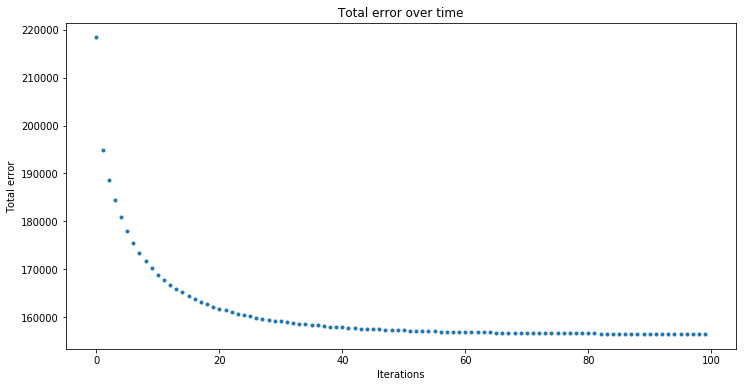

In [48]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0,len(SE_0)),SE_0,'.')
plt.xlabel('Iterations'); plt.ylabel('Total error')
plt.title('Total error over time')
plt.show(); plt.close()

Above is an example plot which shows the error over time. Notice the rapid decrease in the beginning and the slow decrease of the error in the final iterations.

In [11]:
U_0,M_0,SE_0 = mat_fac(folded_data,X,0) # Done with 0.03,0.3,10,100. Gives 0.

Iterations: 0
SE_train: 2114250.6114910557. RMSE_train: 1.625502503874386
SE_test:  215893.18295419298. RMSE_test:  1.0388670124773884

Iterations: 1
SE_train: 834314.6712030494. RMSE_train: 1.0211142822351282
SE_test:  208344.55160086154. RMSE_test:  1.0205436044620255

Iterations: 2
SE_train: 812379.923566795. RMSE_train: 1.0076019548917114
SE_test:  204544.26320673482. RMSE_test:  1.0111932066301381

Iterations: 3
SE_train: 801344.274462045. RMSE_train: 1.0007347472584023
SE_test:  202665.59429341645. RMSE_test:  1.006538763192611

Iterations: 4
SE_train: 795298.3347571266. RMSE_train: 0.9969524544656834
SE_test:  201481.58540320818. RMSE_test:  1.0035942659853352

Iterations: 5
SE_train: 791239.4717054728. RMSE_train: 0.9944051904925058
SE_test:  200656.21063913417. RMSE_test:  1.0015365309033966

Iterations: 6
SE_train: 788395.4988091203. RMSE_train: 0.9926164733390939
SE_test:  200088.1694431193. RMSE_test:  1.0001178924890939

Iterations: 7
SE_train: 786412.828230544. RMSE_train

Iterations: 61
SE_train: 772271.197810836. RMSE_train: 0.9824135171284194
SE_test:  197133.38795877039. RMSE_test:  0.9927058574851654

Iterations: 62
SE_train: 772252.7256287921. RMSE_train: 0.9824017677391497
SE_test:  197131.04781991153. RMSE_test:  0.9926999653416

Iterations: 63
SE_train: 772235.0627413015. RMSE_train: 0.9823905329771747
SE_test:  197128.8419478605. RMSE_test:  0.9926944112311271

Iterations: 64
SE_train: 772218.1331856207. RMSE_train: 0.9823797645420287
SE_test:  197126.75800415978. RMSE_test:  0.9926891640924741

Iterations: 65
SE_train: 772201.8697163531. RMSE_train: 0.9823694196753743
SE_test:  197124.7849486986. RMSE_test:  0.9926841961325246

Iterations: 66
SE_train: 772186.21283705. RMSE_train: 0.9823594605455126
SE_test:  197122.91289695687. RMSE_test:  0.9926794824670386

Iterations: 67
SE_train: 772171.1099342164. RMSE_train: 0.9823498536969445
SE_test:  197121.13299313438. RMSE_test:  0.9926750008013411

Iterations: 68
SE_train: 772156.5145045923. RMSE_

In [15]:
U_0,M_0,SE_0 = mat_fac(folded_data,X,0)
U_1,M_0,SE_1 = mat_fac(folded_data,X,1)
U_2,M_0,SE_2 = mat_fac(folded_data,X,2)
U_3,M_0,SE_3 = mat_fac(folded_data,X,3)
U_4,M_0,SE_4 = mat_fac(folded_data,X,4)

Iterations: 0
SE_train: 5887336.435781592. RMSE_train: 2.7124943213551393
SE_test:  317696.4057573767. RMSE_test:  1.2602207968103278

Iterations: 1
SE_train: 916106.1036405927. RMSE_train: 1.0699963561565438
SE_test:  224134.37857936524. RMSE_test:  1.0585094247314788

Iterations: 2
SE_train: 749720.9223894099. RMSE_train: 0.9679640450782889
SE_test:  204815.94580330243. RMSE_test:  1.0118645342634525

Iterations: 3
SE_train: 704307.019038756. RMSE_train: 0.9381891770974127
SE_test:  196718.53138484817. RMSE_test:  0.9916607594114939

Iterations: 4
SE_train: 682228.2864577173. RMSE_train: 0.9233668343334028
SE_test:  192007.02975202922. RMSE_test:  0.9797134182463044

Iterations: 5
SE_train: 667798.5910805106. RMSE_train: 0.9135496584888793
SE_test:  188681.02032364858. RMSE_test:  0.9711908891720951

Iterations: 6
SE_train: 656564.4419998839. RMSE_train: 0.9058328987839566
SE_test:  186052.88716615958. RMSE_test:  0.9644033236710681

Iterations: 7
SE_train: 646992.0490840077. RMSE_tr

Iterations: 61
SE_train: 495656.7205407743. RMSE_train: 0.7870456264437062
SE_test:  158861.9685479496. RMSE_test:  0.8911492818804354

Iterations: 62
SE_train: 494882.4356007058. RMSE_train: 0.7864306486500915
SE_test:  158761.01962821974. RMSE_test:  0.8908660962506103

Iterations: 63
SE_train: 494134.6482193413. RMSE_train: 0.7858362597656541
SE_test:  158664.0345551547. RMSE_test:  0.8905939453380545

Iterations: 64
SE_train: 493412.27529790316. RMSE_train: 0.7852616446724966
SE_test:  158570.84533885287. RMSE_test:  0.8903323676530365

Iterations: 65
SE_train: 492714.2791358558. RMSE_train: 0.784706020479465
SE_test:  158481.28905863684. RMSE_test:  0.8900809150105145

Iterations: 66
SE_train: 492039.6659247316. RMSE_train: 0.7841686356336889
SE_test:  158395.2081041288. RMSE_test:  0.8898391532790119

Iterations: 67
SE_train: 491387.4842344221. RMSE_train: 0.7836487690033488
SE_test:  158312.4503653978. RMSE_test:  0.8896066629831131

Iterations: 68
SE_train: 490756.82349859184. 

Iterations: 22
SE_train: 565549.5521694226. RMSE_train: 0.840707151524065
SE_test:  168128.8843952052. RMSE_test:  0.9167703767640218

Iterations: 23
SE_train: 562066.7318464813. RMSE_train: 0.8381144929354314
SE_test:  167589.11613410164. RMSE_test:  0.9152975740403821

Iterations: 24
SE_train: 558724.634984534. RMSE_train: 0.8356190276119931
SE_test:  167076.05543082216. RMSE_test:  0.913895444855944

Iterations: 25
SE_train: 555518.6512634724. RMSE_train: 0.8332181713392477
SE_test:  166588.41065022463. RMSE_test:  0.9125607772334797

Iterations: 26
SE_train: 552444.2833537197. RMSE_train: 0.8309093620936441
SE_test:  166125.05942021403. RMSE_test:  0.9112907891620345

Iterations: 27
SE_train: 549497.0100485225. RMSE_train: 0.8286899600454795
SE_test:  165684.95938249028. RMSE_test:  0.9100828886595786

Iterations: 28
SE_train: 546672.2262586516. RMSE_train: 0.8265572040052044
SE_test:  165267.0912258194. RMSE_test:  0.9089345202582265

Iterations: 29
SE_train: 543965.2347778812. RM

Iterations: 82
SE_train: 484344.50658780726. RMSE_train: 0.7780125445618887
SE_test:  157139.56069678877. RMSE_test:  0.8863029062274425

Iterations: 83
SE_train: 483955.1517244503. RMSE_train: 0.7776997673271233
SE_test:  157096.55611910525. RMSE_test:  0.8861816201231658

Iterations: 84
SE_train: 483577.12856656633. RMSE_train: 0.7773959726957373
SE_test:  157054.848467888. RMSE_test:  0.8860639758910593

Iterations: 85
SE_train: 483210.00666231796. RMSE_train: 0.7771008250751685
SE_test:  157014.3812175274. RMSE_test:  0.8859498155097504

Iterations: 86
SE_train: 482853.374069913. RMSE_train: 0.776814002955921
SE_test:  156975.10095860795. RMSE_test:  0.8858389896266565

Iterations: 87
SE_train: 482506.83658088144. RMSE_train: 0.7765351983484743
SE_test:  156936.95720490502. RMSE_test:  0.8857313570246871

Iterations: 88
SE_train: 482170.01696565945. RMSE_train: 0.7762641162334264
SE_test:  156899.90221228058. RMSE_test:  0.8856267841214179

Iterations: 89
SE_train: 481842.554242905

Iterations: 43
SE_train: 513662.8826171227. RMSE_train: 0.8012139508735715
SE_test:  161278.69763524903. RMSE_test:  0.8978998725349138

Iterations: 44
SE_train: 512207.99074542976. RMSE_train: 0.8000784724411436
SE_test:  161072.8455491323. RMSE_test:  0.8973266611256686

Iterations: 45
SE_train: 510809.2788652244. RMSE_train: 0.7989853185749272
SE_test:  160875.7923803673. RMSE_test:  0.8967776077632076

Iterations: 46
SE_train: 509464.18684590777. RMSE_train: 0.7979326583657637
SE_test:  160687.10093459513. RMSE_test:  0.89625153759481

Iterations: 47
SE_train: 508170.27628191106. RMSE_train: 0.7969187403128815
SE_test:  160506.35814814013. RMSE_test:  0.895747338510624

Iterations: 48
SE_train: 506925.226008412. RMSE_train: 0.7959418902012093
SE_test:  160333.17395953476. RMSE_test:  0.8952639584564199

Iterations: 49
SE_train: 505726.82727891556. RMSE_train: 0.79500050860287
SE_test:  160167.18021836484. RMSE_test:  0.8948004028061471

Iterations: 50
SE_train: 504572.9787509596. R

Iterations: 3
SE_train: 706286.4488928383. RMSE_train: 0.9395066257611383
SE_test:  196982.8292704261. RMSE_test:  0.9923242201049972

Iterations: 4
SE_train: 683889.2105744611. RMSE_train: 0.9244901459679157
SE_test:  192228.1541277251. RMSE_test:  0.9802749478866631

Iterations: 5
SE_train: 669445.6727377038. RMSE_train: 0.9146755699855992
SE_test:  188858.63173252204. RMSE_test:  0.971645459380054

Iterations: 6
SE_train: 658115.8671756715. RMSE_train: 0.9069024836361823
SE_test:  186117.00211820196. RMSE_test:  0.9645670680512415

Iterations: 7
SE_train: 648183.5022239055. RMSE_train: 0.9000329245834076
SE_test:  183725.57918922225. RMSE_test:  0.958350157609914

Iterations: 8
SE_train: 639124.1886795032. RMSE_train: 0.8937211539256382
SE_test:  181603.1598270684. RMSE_test:  0.9527985914413459

Iterations: 9
SE_train: 630830.3645088245. RMSE_train: 0.8879033716754148
SE_test:  179724.80050950125. RMSE_test:  0.9478582864162604

Iterations: 10
SE_train: 623253.0929692243. RMSE_trai

Iterations: 64
SE_train: 491501.5043010583. RMSE_train: 0.7837396814757919
SE_test:  157064.61825594326. RMSE_test:  0.8860915348066613

Iterations: 65
SE_train: 490827.6646595295. RMSE_train: 0.7832022507715571
SE_test:  156972.9915199265. RMSE_test:  0.8858330376339629

Iterations: 66
SE_train: 490176.56454585365. RMSE_train: 0.7826826057537204
SE_test:  156884.5991371358. RMSE_test:  0.8855835937066451

Iterations: 67
SE_train: 489547.24901379796. RMSE_train: 0.7821800189822081
SE_test:  156799.31661445403. RMSE_test:  0.885342859211512

Iterations: 68
SE_train: 488938.80666383024. RMSE_train: 0.7816937948072323
SE_test:  156717.02540045403. RMSE_test:  0.8851105064761396

Iterations: 69
SE_train: 488350.36767942604. RMSE_train: 0.7812232680498121
SE_test:  156637.61252966756. RMSE_test:  0.884886223017696

Iterations: 70
SE_train: 487781.1019570947. RMSE_train: 0.7807678027367627
SE_test:  156560.97028897813. RMSE_test:  0.8846697106494227

Iterations: 71
SE_train: 487230.217322298

Iterations: 25
SE_train: 555645.8661981164. RMSE_train: 0.8333135702311081
SE_test:  168567.2576737984. RMSE_test:  0.9179647759634958

Iterations: 26
SE_train: 552389.9317926922. RMSE_train: 0.8308684870831673
SE_test:  168079.9092112785. RMSE_test:  0.9166368415057073

Iterations: 27
SE_train: 549283.3084283146. RMSE_train: 0.8285288039288773
SE_test:  167618.05678207273. RMSE_test:  0.9153766011335247

Iterations: 28
SE_train: 546319.3043715304. RMSE_train: 0.8262903555993766
SE_test:  167180.24365683986. RMSE_test:  0.914180351945864

Iterations: 29
SE_train: 543491.1884032692. RMSE_train: 0.8241488633862163
SE_test:  166765.0689720636. RMSE_test:  0.9130445105808778

Iterations: 30
SE_train: 540792.3076519931. RMSE_train: 0.8221000282138116
SE_test:  166371.19528672943. RMSE_test:  0.9119656371573122

Iterations: 31
SE_train: 538216.1710753355. RMSE_train: 0.8201395989477641
SE_test:  165997.3532636578. RMSE_test:  0.9109404512327322

Iterations: 32
SE_train: 535756.5061714987. RM

Iterations: 85
SE_train: 483138.4907366727. RMSE_train: 0.7770433168070104
SE_test:  158425.30032761773. RMSE_test:  0.8899214515889529

Iterations: 86
SE_train: 482776.7728691924. RMSE_train: 0.7767523825461332
SE_test:  158377.14933673156. RMSE_test:  0.8897862021809978

Iterations: 87
SE_train: 482424.1336364403. RMSE_train: 0.7764686454059286
SE_test:  158330.2841756046. RMSE_test:  0.8896545447442712

Iterations: 88
SE_train: 482080.2535830887. RMSE_train: 0.7761918561034957
SE_test:  158284.66853301736. RMSE_test:  0.889526378843016

Iterations: 89
SE_train: 481744.8282715556. RMSE_train: 0.7759217769032077
SE_test:  158240.2679143492. RMSE_test:  0.8894016090468294

Iterations: 90
SE_train: 481417.56746385846. RMSE_train: 0.7756581809991663
SE_test:  158197.04948122223. RMSE_test:  0.8892801444872597

Iterations: 91
SE_train: 481098.1943485557. RMSE_train: 0.7754008519305663
SE_test:  158154.98190150558. RMSE_test:  0.889161898442788

Iterations: 92
SE_train: 480786.4448099818. 

0.8884 0.8808 0.8848 0.8846 0.8853

0.005, 0.05, 12, 100